In [1]:
# What is different in this kernel:
# - data preprocessing was modularised and hopefully made more clear, as repetitative actions were moved into a separate function
# - LightGBM hyperparameters  were taken from my another kernel, where they were tuned to the `application` data subset only:
#   https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-746
#
# What was borrowed in this kernel:
# This script is a fork of the awesome kernel by olivier, that insiper a lot of kernels on this competition:
# https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm
# It also uses memory-footprint-reduction technique copied over from this very clear and useful kernel:
# https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# The tiny add-on to store OOF predictions on the training dataset was taken from this kernel:
# https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/


import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc


In [2]:

PATH='./'

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df
    
def average_dummies(df, dummy_col, count_col, gb_col, preffix='', del_input=True):
    print('DF shape : ', df.shape)

    if dummy_col:
        print('transform to dummies')
        df = pd.concat([df, pd.get_dummies(df[dummy_col])], axis=1).drop(dummy_col, axis=1)
    
    if count_col and gb_col:
        print('Counting buros')
        df_counts = df[[gb_col, count_col]].groupby(gb_col).count()
        df[count_col] = df[gb_col].map(df_counts[count_col])
    
    avg_df = None
    if gb_col:
        print('averaging ')
        avg_df = df.groupby(gb_col).mean()
        
    if preffix:
        avg_df.columns = [preffix + f_ for f_ in avg_df.columns]
        print(avg_df.head())
        
    print(df.head())
    
    if del_input:
        print('Deleting input')
        del df
        gc.collect()
    
    if avg_df is not None:
        print(avg_df.head())
        print(avg_df.columns.values)
        return avg_df
    elif not del_input:
        return df
    else:
        return None
    
def build_model_input():
    print('Read Bureau_Balance')
    buro_bal = import_data(PATH+'/bureau_balance.csv')
    avg_buro_bal = average_dummies(buro_bal, dummy_col='STATUS', count_col='MONTHS_BALANCE', gb_col='SK_ID_BUREAU', preffix='avg_buro_')

    print('Read Bureau')
    buro_full = import_data(PATH+'/bureau.csv')
    buro_full = average_dummies(buro_full, dummy_col=['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], count_col=None, gb_col=None, preffix=None, del_input=False)
    print('Merge with buro avg')
    buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))
    avg_buro = average_dummies(buro_full, dummy_col=None, count_col='SK_ID_BUREAU', gb_col='SK_ID_CURR', preffix='avg_buro_', del_input=True)

    print('Read prev')
    prev = import_data(PATH+'/previous_application.csv')
    prev_cat_features = [ f_ for f_ in prev.columns if prev[f_].dtype == 'object'  or prev[f_].dtype.name == 'category'  ]
    avg_prev = average_dummies(prev, dummy_col=prev_cat_features, count_col='SK_ID_PREV', gb_col='SK_ID_CURR', preffix='prev_')

    print('Reading POS_CASH')
    pos = import_data(PATH+'/POS_CASH_balance.csv')
    avg_pos = average_dummies(pos, dummy_col='NAME_CONTRACT_STATUS', count_col='SK_ID_PREV', gb_col='SK_ID_CURR', preffix='pos_')

    print('Reading CC balance')
    cc_bal = import_data(PATH+'/credit_card_balance.csv')
    avg_cc_bal = average_dummies(cc_bal, dummy_col='NAME_CONTRACT_STATUS', count_col='SK_ID_PREV', gb_col='SK_ID_CURR', preffix='cc_bal_')

    print('Reading Installments')
    inst = import_data(PATH+'/installments_payments.csv')
    avg_inst = average_dummies(inst, dummy_col=None, count_col='SK_ID_PREV', gb_col='SK_ID_CURR', preffix='inst_')

    print('Read data and test')
    data = import_data(PATH+'/application_train.csv')
    test = import_data(PATH+'/application_test.csv')
    print('Shapes : ', data.shape, test.shape)
    
    y = data['TARGET']
    del data['TARGET']
    
    categorical_feats = [ f for f in data.columns if data[f].dtype == 'object'  or data[f].dtype.name == 'category' ]
    print('---------------------')
    print(categorical_feats)
    for f_ in categorical_feats:
        data[f_], indexer = pd.factorize(data[f_])
        test[f_] = indexer.get_indexer(test[f_])
    
    print('Merging')
    data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    
    del avg_buro, avg_prev
    gc.collect()

    print('Done with data preparation')
    return data, test, y


def train_model(data_, test_, y_, folds_):

    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    
    feature_importance_df = pd.DataFrame()
    
    feats = [f for f in data_.columns if f not in ['SK_ID_CURR']]
    
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_,y_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        
        #clf = LGBMClassifier(
        #    n_estimators=4000,
        #    learning_rate=0.03,
        #    num_leaves=30,
        #    colsample_bytree=.8,
        #    subsample=.9,
        #    max_depth=7,
        #    reg_alpha=.1,
        #    reg_lambda=.1,
        #    min_split_gain=.01,
        #    min_child_weight=2,
        #    silent=-1,
        #    verbose=-1,
        #)
        
        clf = LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000, learning_rate=0.03)
        opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}
        clf.set_params(**opt_parameters)
        #clf.set_params(is_unbalance=True)
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=500, early_stopping_rounds=100  #30
               )
        
        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        print('Fold {} most important features are: '.format(n_fold + 1))
        for i in np.argsort(fold_importance_df["importance"])[-5:]:
            print('{}  -> {}'.format(fold_importance_df.iloc[i, 0], fold_importance_df.iloc[i, 1]))
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['TARGET'] = sub_preds
    
    df_oof_preds = pd.DataFrame({'SK_ID_CURR':data_['SK_ID_CURR'], 'TARGET':y, 'PREDICTION':oof_preds})
    #df_oof_preds = df_oof_preds[['SK_ID_CURR', 'TARGET', 'PREDICTION']]

    return oof_preds, df_oof_preds, test_[['SK_ID_CURR', 'TARGET']], feature_importance_df, roc_auc_score(y, oof_preds)
    

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')


def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig('roc_curve.png')




In [3]:
gc.enable()
# Build model inputs
data, test, y = build_model_input()


Read Bureau_Balance
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
DF shape :  (27299925, 3)
transform to dummies
Counting buros
averaging 
              avg_buro_MONTHS_BALANCE  avg_buro_0  avg_buro_1  avg_buro_2  \
SK_ID_BUREAU                                                                
5001709                            97    0.000000         0.0         0.0   
5001710                            83    0.060241         0.0         0.0   
5001711                             4    0.750000         0.0         0.0   
5001712                            19    0.526316         0.0         0.0   
5001713                            22    0.000000         0.0         0.0   

              avg_buro_3  avg_buro_4  avg_buro_5  avg_buro_C  avg_buro_X  
SK_ID_BUREAU                                                              
5001709              0.0         0.0         0.0    0.886598    0.113402  
5001710              0.0         0.0  

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%
DF shape :  (1670214, 37)
transform to dummies
Counting buros
averaging 
            prev_SK_ID_PREV  prev_AMT_ANNUITY  prev_AMT_APPLICATION  \
SK_ID_CURR                                                            
100001                    1       3951.000000              24835.50   
100002                    1       9251.775391             179055.00   
100003                    3      56553.988281             435436.50   
100004                    1       5357.250000              24282.00   
100005                    2       4813.200195              22308.75   

            prev_AMT_CREDIT  prev_AMT_DOWN_PAYMENT  prev_AMT_GOODS_PRICE  \
SK_ID_CURR                                                                 
100001             23787.00                 2520.0               24835.5   
100002            179055.00                    0.0              179055.0   
100003            484

            prev_SK_ID_PREV  prev_AMT_ANNUITY  prev_AMT_APPLICATION  \
SK_ID_CURR                                                            
100001                    1       3951.000000              24835.50   
100002                    1       9251.775391             179055.00   
100003                    3      56553.988281             435436.50   
100004                    1       5357.250000              24282.00   
100005                    2       4813.200195              22308.75   

            prev_AMT_CREDIT  prev_AMT_DOWN_PAYMENT  prev_AMT_GOODS_PRICE  \
SK_ID_CURR                                                                 
100001             23787.00                 2520.0               24835.5   
100002            179055.00                    0.0              179055.0   
100003            484191.00                 3442.5              435436.5   
100004             20106.00                 4860.0               24282.0   
100005             20076.75                 44

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%
DF shape :  (10001358, 8)
transform to dummies
Counting buros
averaging 
            pos_SK_ID_PREV  pos_MONTHS_BALANCE  pos_CNT_INSTALMENT  \
SK_ID_CURR                                                           
100001                   9          -72.555556            4.000000   
100002                  19          -10.000000           24.000000   
100003                  28          -43.785714           10.109375   
100004                   4          -25.500000            3.750000   
100005                  11          -20.000000           11.703125   

            pos_CNT_INSTALMENT_FUTURE  pos_SK_DPD  pos_SK_DPD_DEF  pos_Active  \
SK_ID_CURR                                                                      
100001                       1.444336    0.777778        0.777778    0.777778   
100002                      15.000000    0.000000        0.000000    1.000000   
100003  

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
DF shape :  (13605401, 8)
Counting buros
averaging 
            inst_SK_ID_PREV  inst_NUM_INSTALMENT_VERSION  \
SK_ID_CURR                                                 
100001                    7                     1.142578   
100002                   19                     1.052734   
100003                   25                     1.040039   
100004                    3                     1.333008   
100005                    9                     1.111328   

            inst_NUM_INSTALMENT_NUMBER  inst_DAYS_INSTALMENT  \
SK_ID_CURR                                                     
100001                        2.714286               -2188.0   
100002                       10.000000                -295.0   
100003                        5.080000               -1378.0   
100004                        2.000000                -754.0   
100005                        5.000000 

Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.798451	valid_1's auc: 0.783842
[1000]	training's auc: 0.820287	valid_1's auc: 0.787344
[1500]	training's auc: 0.837393	valid_1's auc: 0.788415
[2000]	training's auc: 0.852969	valid_1's auc: 0.788823
Early stopping, best iteration is:
[1939]	training's auc: 0.851095	valid_1's auc: 0.78892
Fold 1 most important features are: 
AMT_CREDIT  -> 463
DAYS_BIRTH  -> 506
EXT_SOURCE_1  -> 629
EXT_SOURCE_2  -> 714
EXT_SOURCE_3  -> 783
Fold  1 AUC : 0.788920
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.800075	valid_1's auc: 0.776312
[1000]	training's auc: 0.821123	valid_1's auc: 0.780211
[1500]	training's auc: 0.838233	valid_1's auc: 0.781462
[2000]	training's auc: 0.853313	valid_1's auc: 0.782107
Early stopping, best iteration is:
[2005]	training's auc: 0.853473	valid_1's auc: 0.782164
Fold 2 most important features are: 
AMT_CREDIT  -> 461
DAYS_BIRTH  -> 512
EXT_SOURCE_

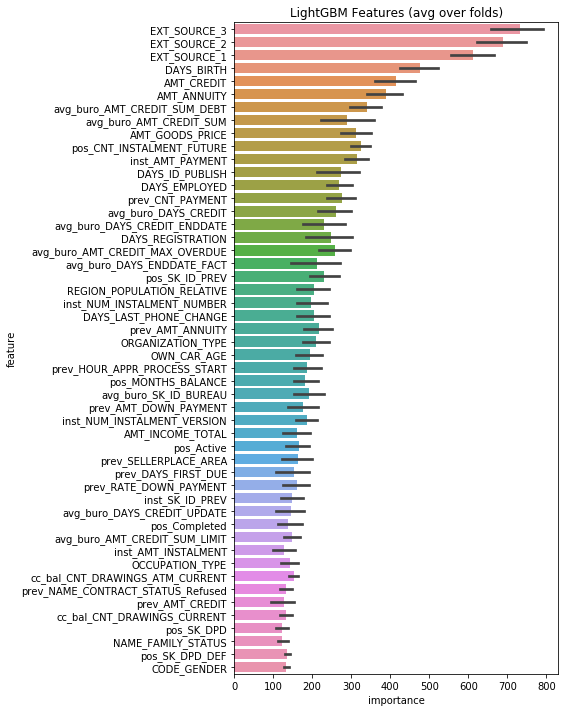

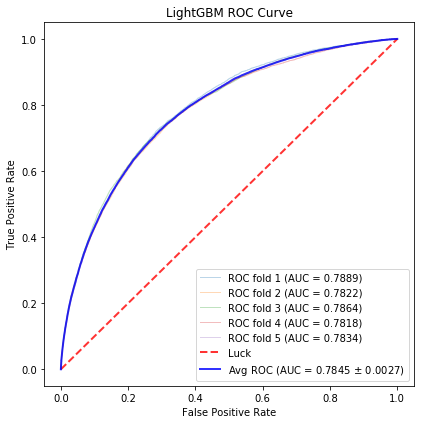

In [4]:
# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=31416)#546789)
# Train model and get oof and test predictions
oof_preds, df_oof_preds, test_preds, importances, score = train_model(data, test, y, folds)
# Save test predictions
from datetime import datetime
now = datetime.now()
score = str(round(score, 6)).replace('.', '')
sub_file = 'submission_5x-average-LGB-run-v01_' + score + '_' + str(now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
test_preds.to_csv(sub_file, index=False)
#Save OOF predictions
oof_file = 'train_5x-LGB-run-v01-oof_' + score + '_' + str(now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
df_oof_preds.to_csv(oof_file, index=False)
# Display a few graphs
folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(data,y)]
display_importances(feature_importance_df_=importances)
display_roc_curve(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)
#display_precision_recall(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)
